# Processing the final dataset



In [2]:
import ee
import geemap

# Authenticate to Earth Engine
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

data_folder = "projects/amazon-forest-regrowth/assets"

In [3]:
# region of interest is Amazonia
roi = ee.FeatureCollection(f"{data_folder}/raw/biomes_br").first().geometry()
# For specific biomes, the feature "CD_Bioma" is:
# 0 = Amazonia
# 1 = Caatinga
# 2 = Cerrado
# 3 = Mata Atlantica
# 4 = Pampa
# 5 = Pantanal

# dist = ee.Image("projects/amazon-forest-regrowth/assets/distance_mat_1km")
# age_agbd = ee.Image(f"{data_folder}/age_agbd")

# dist_sec = dist.updateMask(age_agbd.select("age"))
# dist_sec
# map = geemap.Map()
# map.centerObject(roi, 5)
# map.addLayer(dist_sec, {"min": 0, "max": 5000}, "Distance")
# map


In [4]:
years = 0

age_agbd = ee.Image(f"{data_folder}/age_agbd")
categorical = ee.Image(f"{data_folder}/categorical")
sur_cover = ee.Image(f"{data_folder}/sur_cover").rename("sur_cover")
one_hectare_mask = ee.Image(f"{data_folder}/one_hectare_mask")
mature_biomass = ee.Image(f"{data_folder}/mature_biomass_1km")
cwd = ee.Image(f"{data_folder}/raw/cwd_chave").float().rename("cwd")
yearly_mean_prec = ee.Image(f"{data_folder}/yearly_mean_prec")
yearly_SI = ee.Image(f"{data_folder}/yearly_SI")

distance = mature_biomass.fastDistanceTransform().sqrt().multiply(ee.Image.pixelArea().sqrt()).rename("distance")

# Function to buffer and calculate mean
def buffer_and_calculate_mean(f):
    distance = ee.Number(f.get('distance'))
    buffered = ee.Feature(f.buffer(distance.add(100), 1))
    mean_value = mature_biomass.reduceRegion(ee.Reducer.mean().unweighted(), buffered.geometry(), 100,  maxPixels=1e13)
    return buffered.set(mean_value)

if (years == 0):
    land_use_years = ee.Image(f"{data_folder}/land_use")
    name = "all_LULC"
else:
    land_use_years = ee.Image(f"{data_folder}/land_use_{years}_years")
    name = f"{years}y_LULC"

combined_mask = one_hectare_mask.And(land_use_years.select("last_LU")) \
    .And(distance.gt(100).And(distance.lt(5000)))

unified_data = (
    age_agbd.addBands(
        [land_use_years, cwd, categorical, sur_cover, yearly_mean_prec, yearly_SI]
    )
    .updateMask(combined_mask)
)

unified_data_fc = unified_data.stratifiedSample(
    numPoints = 5000, classBand = 'ecoreg', region = unified_data.geometry(), geometries=True
)

pts = distance.reduceRegions(unified_data_fc, ee.Reducer.first().setOutputs(["distance"]))

pts = pts.map(buffer_and_calculate_mean)

# Export an ee.FeatureCollection to Google Drive, adjusting the description based on the years
task = ee.batch.Export.table.toDrive(
    collection=pts, description=name
)

task.start()


In [18]:
years = 15

if (years == 0):
    land_use_years = ee.Image(f"{data_folder}/land_use")
    name = "all_LULC_1km"
else:
    land_use_years = ee.Image(f"{data_folder}/land_use_{years}_years")
    name = f"{years}y_LULC_1km_30m"

age_agbd = ee.Image(f"{data_folder}/age_agbd")
categorical = ee.Image(f"{data_folder}/categorical")
sur_cover = ee.Image(f"{data_folder}/sur_cover").rename("sur_cover")
one_hectare_mask = ee.Image(f"{data_folder}/one_hectare_mask")
cwd = ee.Image(f"{data_folder}/raw/cwd_chave").float().rename("cwd")
yearly_mean_prec = ee.Image(f"{data_folder}/yearly_mean_prec")
yearly_SI = ee.Image(f"{data_folder}/yearly_SI")
mature_biomass = ee.Image("projects/amazon-forest-regrowth/assets/mature_biomass_1km")

distance = mature_biomass.fastDistanceTransform().sqrt() \
    .multiply(ee.Image.pixelArea().sqrt()).rename("distance")


unified_data = (
    age_agbd.addBands([
        categorical, land_use_years, cwd, sur_cover, yearly_mean_prec, yearly_SI]
    )
    .updateMask(one_hectare_mask).updateMask(land_use_years.select("last_LU"))
).clip(roi)

unified_data_fc = unified_data.stratifiedSample(
    numPoints = 100, classBand = 'ecoreg', region = unified_data.geometry(), geometries=True
)

pts = distance.reduceRegions(unified_data_fc, ee.Reducer.first().setOutputs(["distance"]))

# Function to buffer and calculate mean
def buffer_and_calculate_mean(f):
    distance = ee.Number(f.get('distance'))
    f = ee.Feature(f.buffer(distance.add(100), 1))
    mean_value = mature_biomass.reduceRegion(ee.Reducer.mean().unweighted(), \
                                             f.geometry(), 30, maxPixels=1e13)
    return f.set(mean_value)#.centroid()

pts = pts.map(buffer_and_calculate_mean)

# # Export an ee.FeatureCollection to Google Drive, adjusting the description based on the years
task = ee.batch.Export.table.toDrive(
    collection = pts, description = name
)

task.start()

# Export an ee.FeatureCollection as an Earth Engine asset.
# task = ee.batch.Export.table.toAsset(
#     collection = pts, assetId = f"{data_folder}/15y_LULC_1km"
# )

# task.start()



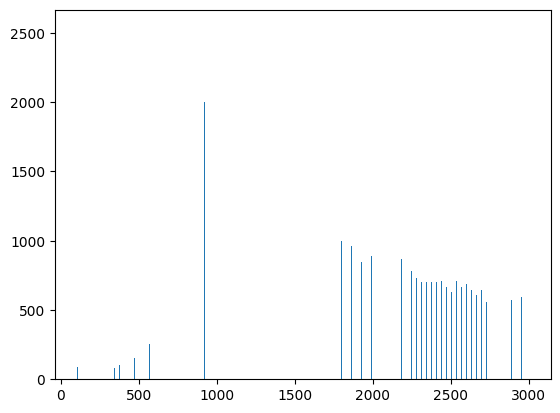

In [45]:

import matplotlib.pyplot as plt

pts = ee.FeatureCollection(f"{data_folder}/15y_LULC_1km")

hist = pts.reduceColumns(
  reducer = ee.Reducer.histogram(),
  selectors = ["distance"]
).get('histogram')

hist = hist.getInfo()

# list(hist.keys())
# Get the bin centers and bin counts
bin_centers = hist['bucketMeans']
bin_counts = hist['histogram']

# # Plot the histogram
plt.bar(bin_centers, bin_counts, width=1)
plt.show()


In [20]:
mature_biomass = ee.Image(f"{data_folder}/mature_biomass_1km")
mature_biomass = mature_biomass.updateMask(mature_biomass.gt(0))

mature_biomass_negative = mature_biomass.unmask(-1)
edge_detec = mature_biomass_negative.zeroCrossing()
distance = edge_detec.fastDistanceTransform().sqrt().multiply(ee.Image.pixelArea().sqrt()).updateMask(mature_biomass).rename("distance_to_edge")


unified_data_fc = mature_biomass.sample(
    numPixels = 10000, region = mature_biomass.geometry(), geometries=True
)
pts = distance.reduceRegions(unified_data_fc, ee.Reducer.first().setOutputs(["distance"]))
pts = pts.map(buffer_and_calculate_mean)

# Export an ee.FeatureCollection to Google Drive, adjusting the description based on the years
task = ee.batch.Export.table.toDrive(
    collection=pts, description="mat_for_biomass_and_distance"
)

task.start()


In [5]:
import ee
import geemap

# Authenticate to Earth Engine
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

first_year = 1985
last_year = 2020

data_folder = "projects/amazon-forest-regrowth/assets"
# This collection is not publicly accessible. To sign up for access,
# please see https://developers.planet.com/docs/integrations/gee/nicfi
nicfi = ee.ImageCollection('projects/planet-nicfi/assets/basemaps/americas')

# Filter basemaps by date and get the first image from filtered results
basemap = nicfi.filter(ee.Filter.date('2016-03-01', '2016-07-01')).first()
basemap2 = nicfi.filter(ee.Filter.date('2018-03-01', '2018-07-01')).first()
basemap3 = nicfi.filter(ee.Filter.date('2020-03-01', '2020-07-01')).first()

sampled_points = ee.FeatureCollection(f"{data_folder}/15y_nn_masked_mature")
mature_biomass = ee.Image(f"{data_folder}/mature_biomass")
mature_biomass_1km = mature_biomass.unmask(0).focalMode(kernelType="circle", radius=5000, units="meters").selfMask()

# Visualization parameters
vis = {'bands': ['R', 'G', 'B'], 'min': 64, 'max': 5454, 'gamma': 1.8}
vis_biomass = {'min': 0, 'max': 300, 'palette': ['black', 'brown', 'yellow', 'green']}

Map = geemap.Map()
Map.centerObject(basemap, 4)
# Map.addLayer(basemap, vis, '2016 mosaic')
Map.addLayer(basemap3, vis, '2020 mosaic')
Map.addLayer(mature_biomass, vis_biomass, "mature_biomass")
Map.addLayer(mature_biomass_1km, vis_biomass, "Mature Biomass 1k")
Map

Map(center=[0.0006306135584438607, -75.32069960585136], controls=(WidgetControl(options=['position', 'transpar…

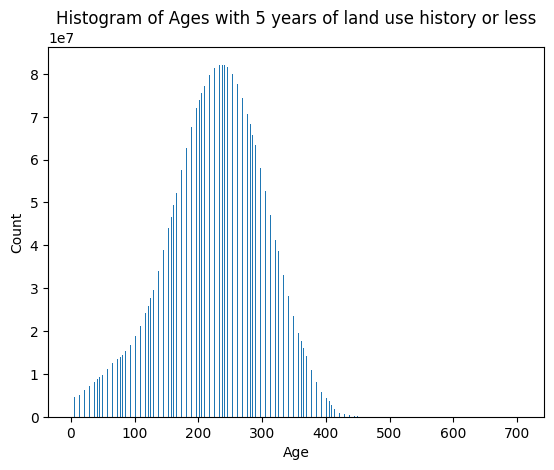

In [38]:
import matplotlib.pyplot as plt

tst = age_agbd.select('age').updateMask(land_use_15_years.select("last_LU")).updateMask(one_hectare_mask)

# 19, 24, 29
histogram_ee = mature_biomass.reduceRegion(
    geometry = tst.geometry(), reducer = ee.Reducer.histogram(), maxPixels=1e13
)

hist = histogram_ee.getInfo()

# list(hist.keys())
# Get the bin centers and bin counts
bin_centers = hist['mature_biomass']['bucketMeans']
bin_counts = hist['mature_biomass']['histogram']

# Plot the histogram
plt.bar(bin_centers, bin_counts, width=1)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages with 5 years of land use history or less')
plt.show()
